<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%206/Assignment/Pytorch_Deteksi_Sarkasme_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import requests
from collections import Counter

# Data Preparation

In [2]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
data = [json.loads(line) for line in requests.get(url).text.strip().split('\n')]
texts = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

## Tokenizing

In [3]:
def tokenize(text):
    return text.lower().split()

word_counts = Counter()
for sentence in texts:
    word_counts.update(tokenize(sentence))

vocab = {"<PAD>": 0, "<UNK>": 1}
for word, _ in word_counts.items():
    vocab[word] = len(vocab)

def encode(sentence, maxlen=100):
    tokens = tokenize(sentence)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < maxlen:
        ids += [0] * (maxlen - len(ids))
    else:
        ids = ids[:maxlen]
    return ids

encoded_texts = [encode(text) for text in texts]
maxlen = 100

## Dataset Loader

In [4]:
X_train, X_test, y_train, y_test = train_test_split(encoded_texts, labels, test_size=0.2, random_state=42)

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = SarcasmDataset(X_train, y_train)
test_dataset = SarcasmDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [5]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
pos_weight = torch.tensor(class_weights[1] / class_weights[0])  # ratio for BCEWithLogits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#RNN Model

### Embedding
Lapisan embedding digunakan untuk mengubah setiap token menjadi vektor berdimensi tetap:

$$
\mathbf{E}: \mathbb{Z}^n \to \mathbb{R}^d
$$

di mana \( n \) adalah jumlah kata dalam kosakata (vocab), dan \( d \) adalah dimensi embedding.

---


In [23]:
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return out

model = SimpleRNNModel(len(vocab), embed_dim=64, hidden_size=128).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training Data

In [25]:
# Step 8: Training Loop (Update with Test Accuracy)
train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluate test accuracy
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            preds = torch.round(torch.sigmoid(outputs))
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

Epoch 1: Train Loss = 0.7779, Train Acc = 0.5285, Test Acc = 0.4392
Epoch 2: Train Loss = 0.7780, Train Acc = 0.5056, Test Acc = 0.4392
Epoch 3: Train Loss = 0.7779, Train Acc = 0.4597, Test Acc = 0.5608
Epoch 4: Train Loss = 0.7779, Train Acc = 0.5251, Test Acc = 0.4392
Epoch 5: Train Loss = 0.7779, Train Acc = 0.4718, Test Acc = 0.4392
Epoch 6: Train Loss = 0.7779, Train Acc = 0.4609, Test Acc = 0.5608
Epoch 7: Train Loss = 0.7779, Train Acc = 0.5363, Test Acc = 0.4392
Epoch 8: Train Loss = 0.7823, Train Acc = 0.4812, Test Acc = 0.5243
Epoch 9: Train Loss = 0.7798, Train Acc = 0.5194, Test Acc = 0.5406
Epoch 10: Train Loss = 0.7754, Train Acc = 0.5357, Test Acc = 0.5404


## Evaluasi

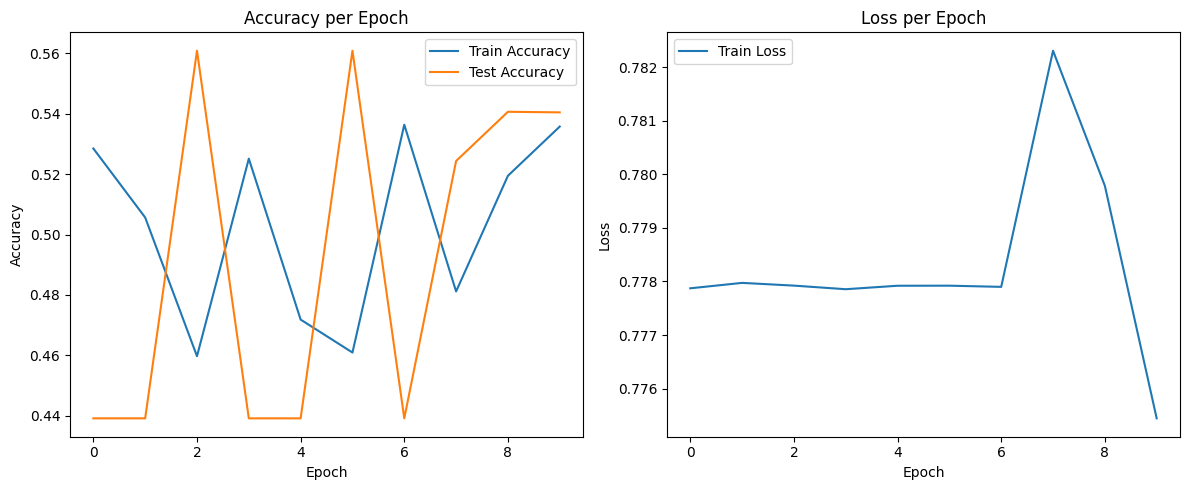

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()

In [27]:
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze(1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = np.round(probs)
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))
print(f"AUC: {roc_auc_score(all_labels, all_probs):.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.6054    0.5187    0.5587      2996
         1.0     0.4804    0.5682    0.5206      2346

    accuracy                         0.5404      5342
   macro avg     0.5429    0.5434    0.5396      5342
weighted avg     0.5505    0.5404    0.5420      5342

AUC: 0.5434


<Figure size 1200x500 with 0 Axes>

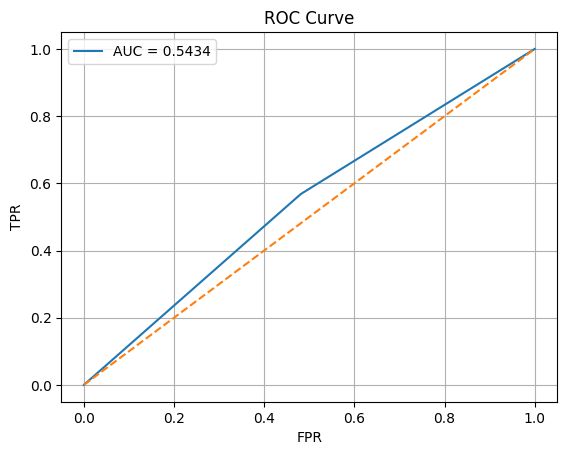

In [29]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(12,5))
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(all_labels, all_probs):.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.grid()
plt.show()

# LSTM Model

### Komponen utama:
- **Forget Gate**:
  $$
  f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
  $$
- **Input Gate**:
  $$
  i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
  $$
  $$
  \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
  $$
- **Cell State Update**:
  $$
  C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
  $$
- **Output Gate**:
  $$
  o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
  $$
  $$
  h_t = o_t * \tanh(C_t)
  $$

## Inisialisasi Model

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            num_layers=num_layers,
                            dropout=0.3,
                            bidirectional=True,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # gabung 2 arah
        out = self.fc(hidden)
        return out.squeeze()

In [16]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
output_dim = 1
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

## Training LSTM

In [19]:
def binary_accuracy(preds, labels):
    preds = torch.round(torch.sigmoid(preds))
    correct = (preds == labels).float()
    return correct.sum() / len(correct)

# TRAINING LOOP
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        acc = binary_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_acc / len(train_loader)

    # VALIDASI
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)
            val_loss += loss.item()
            val_acc += acc.item()

    val_loss /= len(test_loader)
    val_acc /= len(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.0077 | Val Loss: 1.0627 | Train Acc: 0.9978 | Val Acc: 0.8393
Epoch 2/10 | Train Loss: 0.0036 | Val Loss: 1.1064 | Train Acc: 0.9991 | Val Acc: 0.8412
Epoch 3/10 | Train Loss: 0.0034 | Val Loss: 1.2293 | Train Acc: 0.9991 | Val Acc: 0.8388
Epoch 4/10 | Train Loss: 0.0008 | Val Loss: 1.2466 | Train Acc: 0.9999 | Val Acc: 0.8380
Epoch 5/10 | Train Loss: 0.0024 | Val Loss: 1.2392 | Train Acc: 0.9994 | Val Acc: 0.8410
Epoch 6/10 | Train Loss: 0.0046 | Val Loss: 1.0871 | Train Acc: 0.9989 | Val Acc: 0.8407
Epoch 7/10 | Train Loss: 0.0050 | Val Loss: 1.0715 | Train Acc: 0.9986 | Val Acc: 0.8432
Epoch 8/10 | Train Loss: 0.0073 | Val Loss: 0.8937 | Train Acc: 0.9980 | Val Acc: 0.8456
Epoch 9/10 | Train Loss: 0.0064 | Val Loss: 1.1215 | Train Acc: 0.9981 | Val Acc: 0.8427
Epoch 10/10 | Train Loss: 0.0061 | Val Loss: 1.0193 | Train Acc: 0.9984 | Val Acc: 0.8456


## Evaluasi

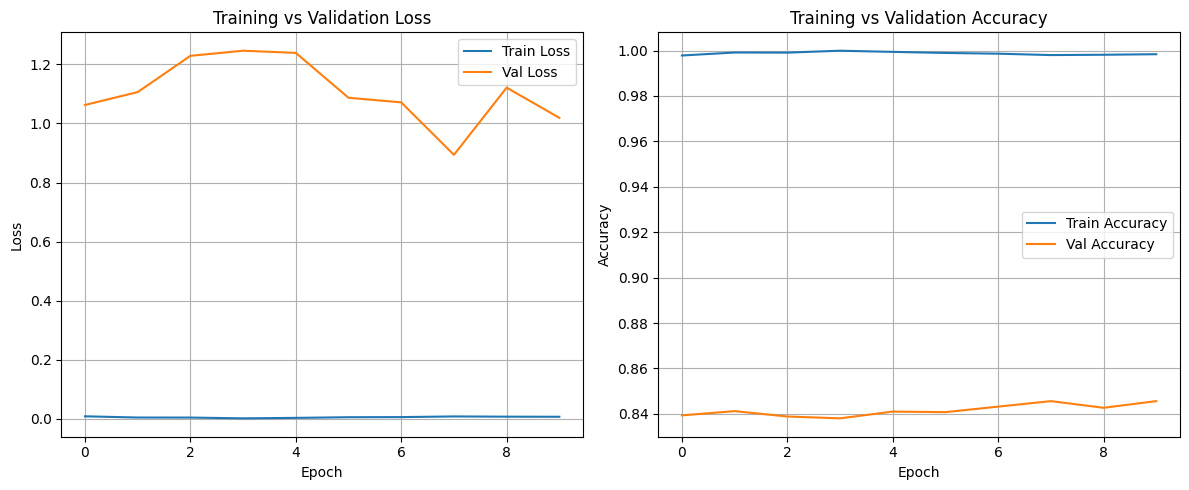

In [22]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        probs = torch.sigmoid(outputs)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

pred_labels = [1 if p >= 0.5 else 0 for p in all_preds]
print("\nClassification Report:")
print(classification_report(all_labels, pred_labels, digits=4))

# ROC AUC & CURVE
auc_score = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
print(f"AUC Score: {auc_score:.4f}")



Classification Report:
              precision    recall  f1-score   support

         0.0     0.8532    0.8752    0.8641      2996
         1.0     0.8352    0.8078    0.8212      2346

    accuracy                         0.8456      5342
   macro avg     0.8442    0.8415    0.8426      5342
weighted avg     0.8453    0.8456    0.8453      5342

AUC Score: 0.9161


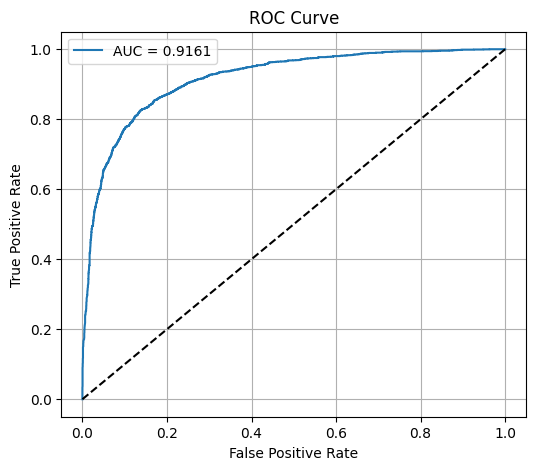

In [23]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

### GRU menyederhanakan LSTM:
- **Update Gate**:
  $$
  z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
  $$
- **Reset Gate**:
  $$
  r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
  $$
- **State Update**:
  $$
  \tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
  $$
  $$
  h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
  $$

## Inisialisasi Model

In [24]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim,
                          num_layers=num_layers,
                          dropout=0.3,
                          bidirectional=True,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return out.squeeze()

In [25]:
# PARAMETER & INSTANSIASI MODEL
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
output_dim = 1
model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

## Training Loop

In [27]:
epochs = 10
train_losses_gru, val_losses_gru = [], []
train_accuracies_gru, val_accuracies_gru = [], []

for epoch in range(epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        acc = binary_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_acc / len(train_loader)

    # VALIDASI
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)
            val_loss += loss.item()
            val_acc += acc.item()

    val_loss /= len(test_loader)
    val_acc /= len(test_loader)

    train_losses_gru.append(train_loss)
    val_losses_gru.append(val_loss)
    train_accuracies_gru.append(train_acc)
    val_accuracies_gru.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.5222 | Val Loss: 0.4300 | Train Acc: 0.7701 | Val Acc: 0.8324
Epoch 2/10 | Train Loss: 0.2731 | Val Loss: 0.4511 | Train Acc: 0.9006 | Val Acc: 0.8486
Epoch 3/10 | Train Loss: 0.1057 | Val Loss: 0.4824 | Train Acc: 0.9674 | Val Acc: 0.8434
Epoch 4/10 | Train Loss: 0.0423 | Val Loss: 0.7071 | Train Acc: 0.9883 | Val Acc: 0.8431
Epoch 5/10 | Train Loss: 0.0221 | Val Loss: 0.8517 | Train Acc: 0.9935 | Val Acc: 0.8416
Epoch 6/10 | Train Loss: 0.0112 | Val Loss: 0.9253 | Train Acc: 0.9968 | Val Acc: 0.8417
Epoch 7/10 | Train Loss: 0.0183 | Val Loss: 0.9154 | Train Acc: 0.9944 | Val Acc: 0.8386
Epoch 8/10 | Train Loss: 0.0207 | Val Loss: 0.8317 | Train Acc: 0.9933 | Val Acc: 0.8468
Epoch 9/10 | Train Loss: 0.0128 | Val Loss: 1.0205 | Train Acc: 0.9962 | Val Acc: 0.8333
Epoch 10/10 | Train Loss: 0.0098 | Val Loss: 1.0663 | Train Acc: 0.9969 | Val Acc: 0.8366


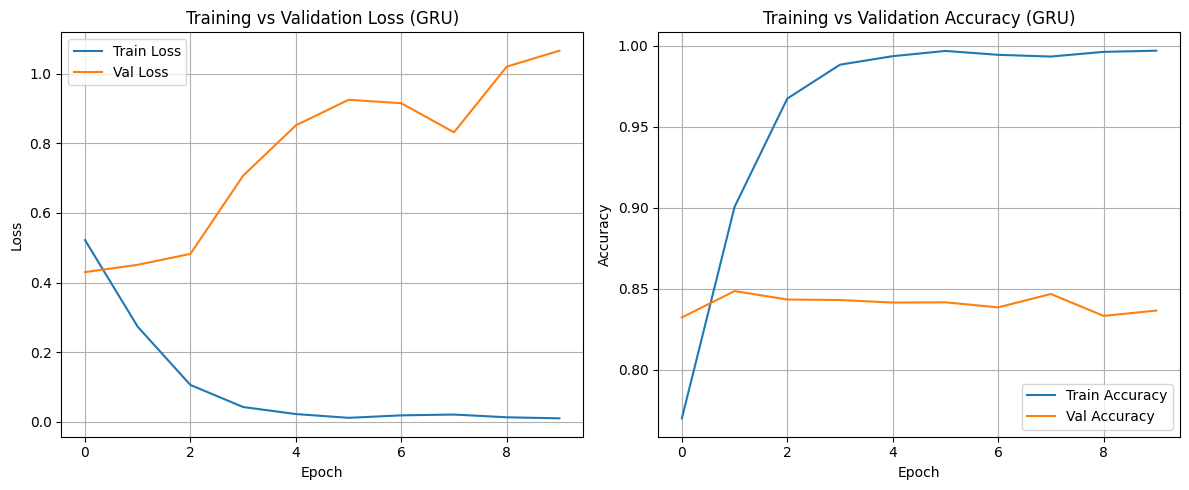

In [28]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_gru, label="Train Loss")
plt.plot(val_losses_gru, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (GRU)")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_gru, label="Train Accuracy")
plt.plot(val_accuracies_gru, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (GRU)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Classification Report (GRU):
              precision    recall  f1-score   support

         0.0     0.8563    0.8515    0.8539      2996
         1.0     0.8117    0.8176    0.8146      2346

    accuracy                         0.8366      5342
   macro avg     0.8340    0.8345    0.8343      5342
weighted avg     0.8367    0.8366    0.8366      5342

AUC Score (GRU): 0.9154


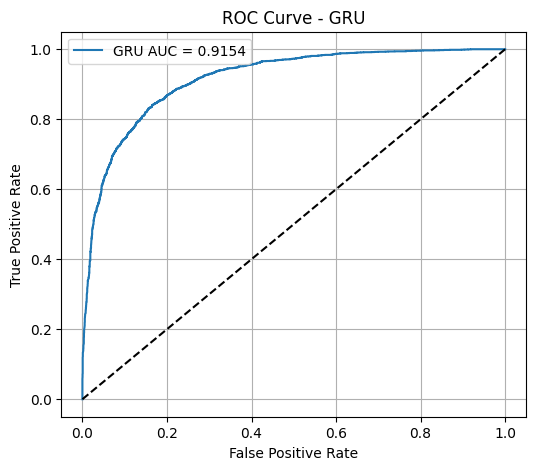

In [29]:
model.eval()
all_preds_gru, all_labels_gru = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        probs = torch.sigmoid(outputs)
        all_preds_gru.extend(probs.cpu().numpy())
        all_labels_gru.extend(labels.cpu().numpy())

pred_labels_gru = [1 if p >= 0.5 else 0 for p in all_preds_gru]
print("\nClassification Report (GRU):")
print(classification_report(all_labels_gru, pred_labels_gru, digits=4))

# ROC AUC & CURVE
auc_score_gru = roc_auc_score(all_labels_gru, all_preds_gru)
fpr_gru, tpr_gru, _ = roc_curve(all_labels_gru, all_preds_gru)
print(f"AUC Score (GRU): {auc_score_gru:.4f}")

# VISUALISASI ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_gru, tpr_gru, label=f"GRU AUC = {auc_score_gru:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GRU")
plt.legend()
plt.grid(True)
plt.show()

# Persamaan Matematis

## Proses Training

Model menggunakan loss function `BCEWithLogitsLoss`, yaitu kombinasi dari sigmoid + binary cross entropy:

$$
\text{Loss} = - \left[ y \cdot \log(\sigma(\hat{y})) + (1 - y) \cdot \log(1 - \sigma(\hat{y})) \right]
$$

Optimasi menggunakan algoritma Adam, yang menggabungkan momentum dan RMSProp:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{w}_t = w_{t-1} - \eta \frac{m_t}{\sqrt{v_t} + \epsilon}
$$

---

## Evaluasi Model

Evaluasi dilakukan dengan beberapa metrik:

- **Akurasi**:
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Presisi**:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall**:
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1-Score**:
  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **ROC Curve**: menunjukkan hubungan antara TPR dan FPR

- **AUC**: area di bawah ROC curve, nilai ideal adalah 1